# Ecommerce Sales SQL linking Python~

#Installing Packages

In [1]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('ecommerce_24-25_sales_flat.csv', 'customers'),
    ('ecommerce_dim_order.csv', 'orders'),
    ('ecommerce_dim_product.csv', 'products'),
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Geniusme2@',
    database='ecommerce_sales'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = "C:/Users/chari/OneDrive/Desktop/MY WORK/Ecommerce-Sales/Ecommerce star schema tables"

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing ecommerce_24-25_sales_flat.csv
NaN values before replacement:
CustomerID          0
OrderDate           0
ProductID           0
Category            0
Quantity Ordered    0
OutOfStock          0
Price               0
Sales               0
City                0
PaymentType         0
dtype: int64

Processing ecommerce_dim_order.csv
NaN values before replacement:
CustomerID          0
OrderDate           0
Quantity Ordered    0
Year                0
Month               0
Month_Name          0
Weekday             0
dtype: int64

Processing ecommerce_dim_product.csv
NaN values before replacement:
ProductID     0
Category      0
Price         0
Sales         0
OutOfStock    0
dtype: int64



#Importing Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Geniusme2@",
                             database = "ecommerce_sales")

cur = db.cursor()


# Buisness Queries~

## 1)Total Categorical Sales

In [4]:
query = """ select upper(Category),round(sum(Sales),2)
            from customers
            group by Category"""

cur.execute(query)

data = cur.fetchall()

df_category = pd.DataFrame(data, columns=['Category','Total Sales'])
df_category.sort_values('Total Sales', ascending=False, inplace=True)
df_category

,Category,Total Sales
4,ELECTRONICS,4968354
0,BEAUTY,4960014
3,CLOTHING,4701789
2,FURNITURE,4404042
1,SPORTS,4194627


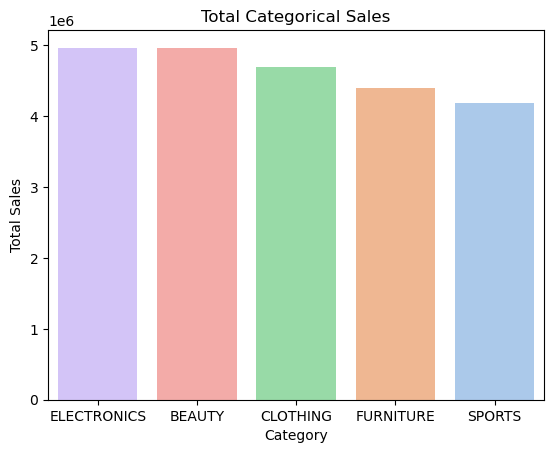

In [5]:
sns.barplot(data= df_category, x= 'Category', y= 'Total Sales', hue= 'Total Sales', palette= 'pastel')
plt.title("Total Categorical Sales")
plt.legend().remove()
plt.show()

## Insights:

- From the analysis, Highest Category sold is Electronics.

## 2)Total Sales City wise~

In [6]:
query = """ select upper(City),round(sum(Sales),2)
            from customers
            group by City"""

cur.execute(query)

data = cur.fetchall()

df_city = pd.DataFrame(data, columns=['City','Total Sales'])
df_city.sort_values('Total Sales', ascending=False, inplace=True)
df_city

,City,Total Sales
4,MUMBAI,3858915
5,BENGALURU,3708849
0,PUNE,3294288
3,DELHI,3151647
6,CHENNAI,3149694
1,KOLKATA,3112833
2,HYDERABAD,2952600


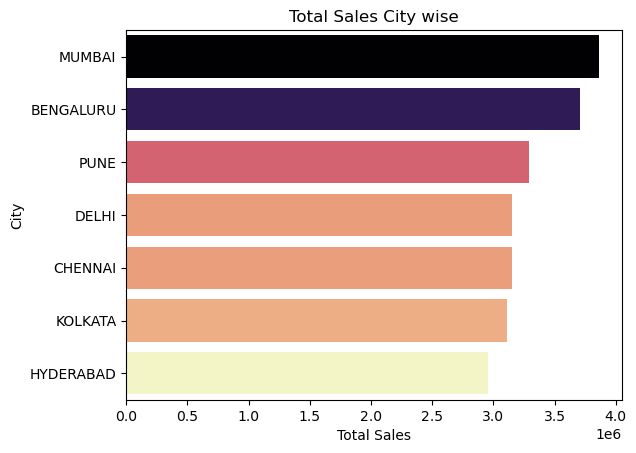

In [7]:
sns.barplot(data= df_city, x= 'Total Sales', y= 'City', hue= 'Total Sales', palette= 'magma_r')

plt.title("Total Sales City wise")
plt.legend().remove()
plt.show()

## Insights:

- Mumbai has the highest revenue generated overall.

## 3)Total Revenue Generated in the year 2024~

In [8]:
query = """ select orders.Year, sum(customers.Sales)
            from orders join customers
            on orders.CustomerID = customers.CustomerID
            where Year = 2024
            group by Year"""

cur.execute(query)

data = cur.fetchall()

"Total Revenue Generated in the year 2024 is :", data[0][1]

('Total Revenue Generated in the year 2024 is :', Decimal('108255366'))

## 3.1)Total Revenue Generated in the year 2025~

#Running the same for the year 2025~

In [9]:
query = """ select orders.Year, sum(customers.Sales)
            from orders join customers
            on orders.CustomerID = customers.CustomerID
            where Year = 2025
            group by Year"""

cur.execute(query)

data = cur.fetchall()

"Total Revenue Generated in the year 2025 is :", data[0][1]

('Total Revenue Generated in the year 2025 is :', Decimal('325160010'))

## Insights:

- Looking at the data, in the year 2024 the buisness generated about 1.2CR worth revenue which increased drastically by 2025 which is about 3.6CR nearly.

## 4)Number of Customers from each City~

In [10]:
query = """ select City, count(CustomerID) 
            from customers
            group by City"""

cur.execute(query)

data = cur.fetchall()

df_cust_num = pd.DataFrame(data, columns=['City','Total Customers'])
df_cust_num.sort_values('Total Customers',ascending=False,inplace=True)
df_cust_num

,City,Total Customers
4,Mumbai,465
3,Delhi,450
5,Bengaluru,438
0,Pune,426
2,Hyderabad,414
1,Kolkata,411
6,Chennai,396


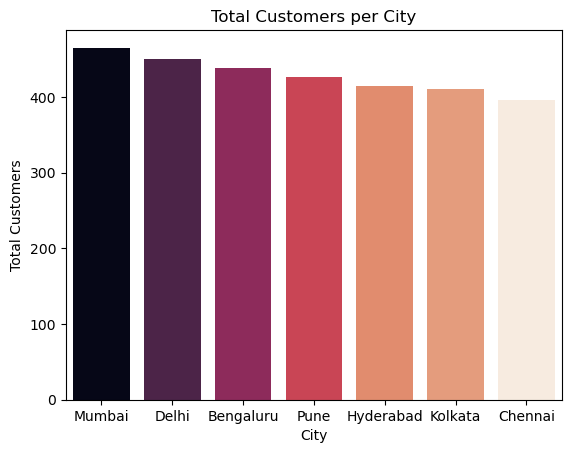

In [11]:
sns.barplot(data= df_cust_num, x= 'City', y= 'Total Customers', hue= 'Total Customers', palette= 'rocket_r')

plt.title("Total Customers per City")
plt.legend().remove()
plt.show()

## Insights:

- From the analysis Mumbai has highest customers and that explains Mumbai being the highest revenue generating city for our buisness. 

## 5)Overall Order Trends monthly~

In [12]:
query = """ select orders.Month_Name, count(customers.ProductID) 
            from orders join customers
            on orders.CustomerID = customers.CustomerID
            group by Month_Name"""

cur.execute(query)

data = cur.fetchall()

df_order_monthly = pd.DataFrame(data, columns=['Month','Orders'])
df_order_monthly['Month Num'] = pd.to_datetime(df_order_monthly['Month'], format='%B').dt.month
df_order_monthly.sort_values('Month Num',inplace=True)
df_order_monthly.set_index('Month Num',inplace=True)
df_order_monthly

,Month,Orders
Month Num,,
1,January,4617
2,February,4500
3,March,5490
4,April,4815
5,May,5157
6,June,3717
7,July,4707
8,August,4050
9,September,4626


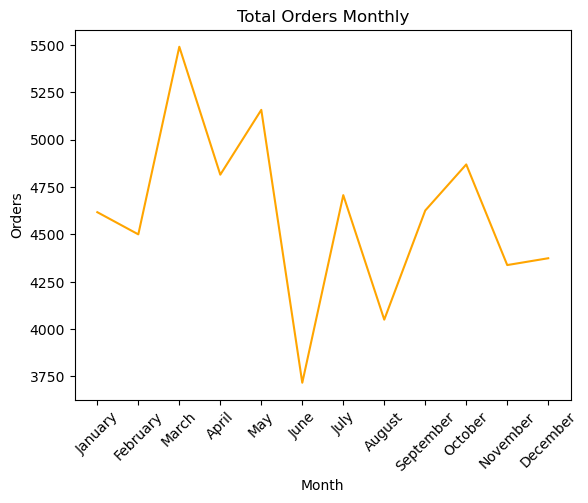

In [13]:
sns.lineplot(data= df_order_monthly, x= 'Month', y= 'Orders', color= 'Orange')
plt.xticks(rotation=45)
plt.title("Total Orders Monthly")
plt.show()

## Insights:

- We can see spikes during March and a dip during June but tends to normalize at the end of the year.

## 6)Average Quantity Ordered per City~

In [14]:
query = """ select round(avg(orders.Quantity_Ordered),2), customers.City as City 
            from orders join customers
            on orders.CustomerID = customers.CustomerID
            group by City """

cur.execute(query)

data = cur.fetchall()

df_quantity = pd.DataFrame(data, columns=['Average Quantity Ordered','City'])
df_quantity.sort_values('Average Quantity Ordered',ascending=False, inplace=True)
df_quantity

,Average Quantity Ordered,City
0,3.03,Pune
3,3.01,Delhi
5,3.00,Bengaluru
1,2.97,Kolkata
2,2.97,Hyderabad
4,2.97,Mumbai
6,2.94,Chennai


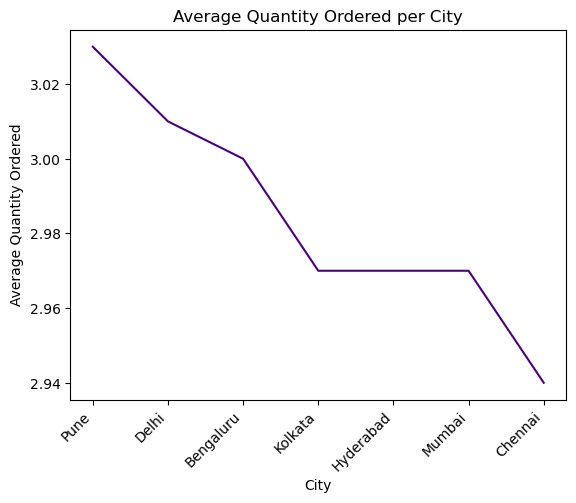

In [15]:
sns.lineplot(data= df_quantity, x= 'City', y= 'Average Quantity Ordered', color= 'indigo')
plt.xticks(rotation=45, ha='right')
plt.title("Average Quantity Ordered per City")
plt.show()

## Insights:

- Average Quantity of products is ordered by Pune. Mumbai having high revenue generated and highest customers count but 
average orders recieved from Mumbai is almost least, however Pune having moderate number of customers and moderate revenue generated
it has highest average quantity of products ordered.

## 7)Percent of Total Revenue contributed by each Category~

In [16]:
query = """ select upper(Category),round(sum(Sales)/ (select sum(Sales) from customers) * 100,2)
            from customers
            group by Category"""

cur.execute(query)

data = cur.fetchall()

df_category_perc = pd.DataFrame(data, columns=['Category','Total Sales Percentage'])
df_category_perc.sort_values('Total Sales Percentage', ascending=False, inplace=True)
df_category_perc

,Category,Total Sales Percentage
4,ELECTRONICS,21.39
0,BEAUTY,21.35
3,CLOTHING,20.24
2,FURNITURE,18.96
1,SPORTS,18.06


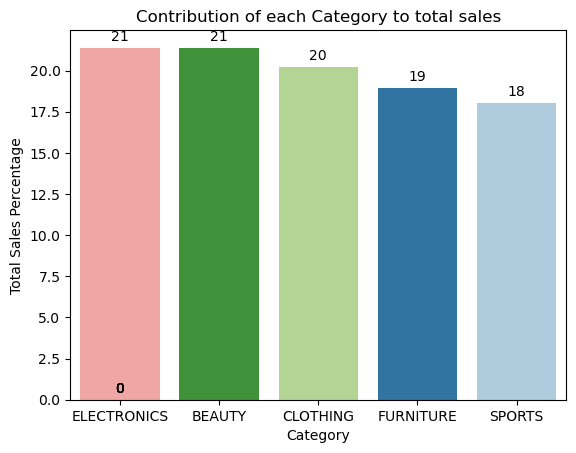

In [17]:
ax = sns.barplot(data= df_category_perc, x= 'Category', y= 'Total Sales Percentage', hue= 'Total Sales Percentage', palette= 'Paired')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

plt.title("Contribution of each Category to total sales")
plt.legend().remove()
plt.show()

## 8)Correlation between Category, Price and number of times it has been purchased~ 

In [18]:
query = """ select upper(Category),count(Quantity_Ordered),round(sum(Sales),2)
            from customers
            group by Category"""

cur.execute(query)

data = cur.fetchall()

df_num_of_purchase = pd.DataFrame(data, columns=['Category','Num of Quantity Purchased','Total Sales'])

df_num_of_purchase

,Category,Num of Quantity Purchased,Total Sales
0,BEAUTY,597,4960014
1,SPORTS,585,4194627
2,FURNITURE,564,4404042
3,CLOTHING,639,4701789
4,ELECTRONICS,615,4968354


In [20]:
df_num_of_purchase_correl = df_num_of_purchase[['Num of Quantity Purchased','Total Sales']].corr()
df_num_of_purchase_correl

,Num of Quantity Purchased,Total Sales
Num of Quantity Purchased,1.000000,0.550423
Total Sales,0.550423,1.000000


## Insights:

- This is a moderate positive correlation.
As the number of quantities purchased increases, the total sales also tend to increase.
But because the value is 0.55 and not closer to 1.0, the relationship is not perfectly linear.
There are other factors (like price differences, discounts, product type, etc.) that also influence total sales.

## 9)Cumilative Sales per month for each year~

In [27]:
 query = """ select Year, Month, sum(Payment)
             over(order by Year, Month) from
             (select orders.Year , orders.Month ,round(sum(customers.Sales),2) as Payment
              from orders join customers
              on orders.CustomerID = customers.CustomerID
              group by Year,Month
              order by Year, Month) as a """

cur.execute(query)

data = cur.fetchall()

df_cumilative = pd.DataFrame(data, columns=['Year','Month','Cumilative Sales'])

df_cumilative

,Year,Month,Cumilative Sales
0,2024,10,37720116
1,2024,11,72716913
2,2024,12,108255366
3,2025,1,145728711
4,2025,2,180297207
5,2025,3,224579988
6,2025,4,261743562
7,2025,5,301315518
8,2025,6,331045371
9,2025,7,368242137


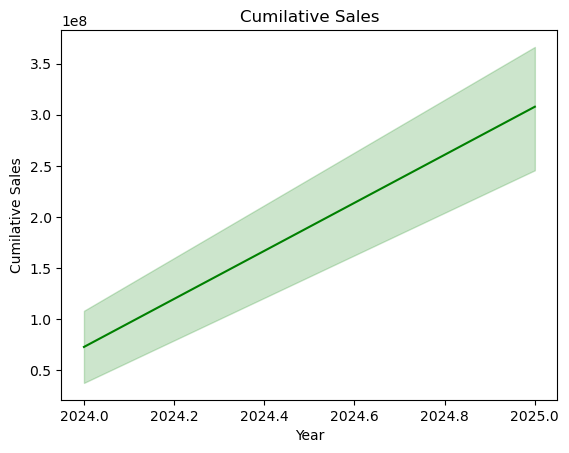

In [35]:
sns.lineplot(data = df_cumilative, x= 'Year', y= 'Cumilative Sales', color= 'green')
plt.title("Cumilative Sales")
plt.show()

## 10)Year over Year Growth rate~

In [49]:
 query = """ with a as (select orders.Year ,round(sum(customers.Sales),2) as Payment
              from orders join customers
              on orders.CustomerID = customers.CustomerID
              group by Year
              order by Year) 
              
              select Year, lag(Payment, 1) over (order by Year) as Previous_Year , Payment , 
              round(( Payment - lag(Payment, 1) over (order by Year)) / lag(Payment, 1) over (order by Year),2) 
              as Year_over_Year_Grwth
              from a """

cur.execute(query)

data = cur.fetchall()

df_YoYG = pd.DataFrame(data, columns=['Year','Previous_Year','Current_Sales','Year_over_Year_Grwth'])

df_YoYG

,Year,Previous_Year,Current_Sales,Year_over_Year_Grwth
0,2024,None,108255366,None
1,2025,108255366,325160010,2.00
